<a target="_blank" href="https://colab.research.google.com/github/trainocate-japan/Machine-Learning-and-Deep-Learning-Hands-on/blob/main/answer/6_ディープラーニング/6-2_Pytorchによる自動車の燃費予測.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 6-2_PyTorchによる自動車の燃費予測
このノートブックでは、PyTorchで回帰の予測モデルを作成します。<br>
予測を行うテーマはKeras / TensorFlowと同じ、1970年代後半から1980年台初めの自動車の燃費を予測することです。

## ライブラリのインポート

In [1]:
# データを処理するための基本的なライブラリ
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# scikit-learnから必要なライブラリをインポート
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score # sklearnの決定係数を使って精度を算出する

# データセットをダウンロードするためのライブラリ
import urllib.request

# PyTorchで使用
import torch
# PyTorchのインポート設定は色々なスタイルがありますが、事前にインポートするとKerasに比べるて非常に多くのインポートを書く必要がある為、
# 今回は使用するたびに全て記載するスタイルをとります。

Google Colaboratory上での出力のデフォルト設定

In [2]:
# pandasのDataframeの出力
pd.set_option('display.max_columns', 500) # 表示列の最大
pd.set_option('display.max_rows', 500) # 表示行の最大
pd.set_option('display.unicode.east_asian_width', True) # 日本語出力時にヘッダのずれを解消
pd.options.display.float_format = '{:,.5f}'.format # 表示桁数の設定

# ノートブックの表示桁数設定。この設定はprint文には作用せず、セルの最後に書いたものを出力する際に適用されます。
%precision 6
# numpy配列の指数表示禁止設定
np.set_printoptions(suppress=True)
# numpy配列の表示桁数設定
np.set_printoptions(precision=6)

## データの準備
データの準備は、torchtensorへの変換以外、Keras / TensorFlowとほとんど同じです。一部異なる点として、データを訓練用（train_x、train_y）、検証用（val_x、val_y）、テスト用（test_x、test_y）にあらかじめ分けておきます。

In [3]:
# ライブラリurllibを使用してデータをダウンロードする
# このデータセットはUCI Machine Learning Repositoryから公開されているAuto MPG データセットです
# https://archive.ics.uci.edu/ml/datasets/auto+mpg


URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
dataset_path = "auto-mpg.data"
urllib.request.urlretrieve(URL, dataset_path)
dataset_path

# データを読み込む
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
mpg_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

# 読み込んだデータを確認する
mpg_dataset.tail(4)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
394,44.00000,4,97.00000,52.00000,"2,130.00000",24.60000,82,2
395,32.00000,4,135.00000,84.00000,"2,295.00000",11.60000,82,1
396,28.00000,4,120.00000,79.00000,"2,625.00000",18.60000,82,1
397,31.00000,4,119.00000,82.00000,"2,720.00000",19.40000,82,1


In [4]:
# 欠損値の含まれる行を削除する
mpg_dataset = mpg_dataset.dropna()

# originは産出国のカテゴリなので、ダミー変数化する。わかりやすくするために、列に名前を付ける
origin=mpg_dataset.pop('Origin') # pop('列名')でその列の値だけを取り出します

mpg_dataset['USA'] = (origin == 1)*1.0 # booleanで値が帰ってきているため1.0を掛けてfloatにしています
mpg_dataset['Europe'] = (origin == 2)*1.0
mpg_dataset['Japan'] = (origin == 3)*1.0

# 説明変数を取り出す
mpg_dataset_x = mpg_dataset.iloc[:,1:10]
mpg_dataset_x.tail(4)

# 目的変数はMPG
mpg_dataset_y = mpg_dataset["MPG"]
mpg_dataset_y.tail(4)

# 訓練データとテストデータに分割（20%をテスト用に使用）
train_x, test_x, train_y, test_y = train_test_split(mpg_dataset_x, mpg_dataset_y, train_size=0.8, test_size=0.2, random_state=0) 
# さらに訓練データを検証データに分割（訓練データの20%を検証用に使用）
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, train_size=0.8, test_size=0.2, random_state=0) 

#トレーニングデータの標準化

train_x_mean = train_x.mean(axis=0) # トレーニングデータ説明変数の平均
train_x_std = train_x.std(axis=0)  # トレーニングデータ説明変数の分散

train_x_scaled = (train_x - train_x_mean) / train_x_std

train_y_mean = train_y.mean(axis=0) # トレーニングデータ説明変数の平均
train_y_std = train_y.std(axis=0)  # トレーニングデータ説明変数の分散

train_y_scaled = (train_y - train_y_mean) / train_y_std

# 検証データの標準化
val_x_scaled = (val_x - train_x_mean) / train_x_std
val_y_scaled = (val_y - train_y_mean) / train_y_std

# テストデータの標準化
test_x_scaled = (test_x - train_x_mean) / train_x_std
test_y_scaled = (test_y - train_y_mean) / train_y_std

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

#### データをtorchtensorに変換する
PyTorchで学習を行うためには、データをtorchtensor型に変換する必要があります。
pandasのDataFrameからは直接変換できないので、まず、numpy配列に変換してからtorchtensorへ変換します。

In [5]:
# torchtensorに変換するためにまず、pandasのDataFrameからnumpy配列に変換しておく。
print("変換前")
print(type(train_x_scaled))
print(train_x_scaled.dtypes)
print(type(train_y_scaled))
print(train_y_scaled.dtypes)

# numpy配列へ変換
train_x_scaled = train_x_scaled.values
train_y_scaled = train_y_scaled.values

# 変換後
print(type(train_x_scaled))
print(type(train_y_scaled))

変換前
<class 'pandas.core.frame.DataFrame'>
Cylinders       float64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year      float64
USA             float64
Europe          float64
Japan           float64
dtype: object
<class 'pandas.core.series.Series'>
float64
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [6]:
# 検証データとテストデータもnumpy配列へ変換
val_x_scaled = val_x_scaled.values
val_y_scaled = val_y_scaled.values
test_x_scaled = test_x_scaled.values
test_y_scaled = test_y_scaled.values

In [7]:
## numpy配列をテンソルに変換
train_x_scaled = torch.Tensor(train_x_scaled).float()
train_y_scaled = torch.Tensor(train_y_scaled .reshape(-1, 1)).float()
val_x_scaled = torch.Tensor(val_x_scaled).float()
val_y_scaled = torch.Tensor(val_y_scaled .reshape(-1, 1)).float()
test_x_scaled = torch.Tensor(test_x_scaled).float()
test_y_scaled = torch.Tensor(test_y_scaled.reshape(-1, 1)).float()
## データをテンソルデータセットインスタンスにする
train_dataset = torch.utils.data.TensorDataset(train_x_scaled, train_y_scaled)
val_dataset = torch.utils.data.TensorDataset(val_x_scaled, val_y_scaled)
test_dataset = torch.utils.data.TensorDataset(test_x_scaled, test_y_scaled)

## モデルの定義
PyTorchのモデル構築は以下の手順で行います。
- torch.nn.Moduleを継承したクラスを定義する
- 作成したクラスにinitメソッドを定義し、モデルの構成を記述する
- 作成したクラスにforwardメソッドを定義し、順伝搬を記述する。

In [8]:
# 乱数シードの固定
torch.manual_seed(0)

# ニューラルネットワークを定義
class Net(torch.nn.Module):

  # 必要な層や活性化関数を定義する
  def __init__(self):
    super(Net, self).__init__()
    self.l1 = torch.nn.Linear(train_x.shape[1], 3)     # 中間層1
    self.a1 = torch.nn.ReLU()  # 活性化関数1
    self.l2 = torch.nn.Linear(3, 3)   # 中間層2
    self.a2 = torch.nn.ReLU()  # 活性化関数2
    self.l3 = torch.nn.Linear(3, 1)     # 出力層

  # 順伝搬を定義。引数のxは、説明変数。
  # 順番に関数を実行し、その結果を次の関数に渡していく
  def forward(self, x):
    x = self.l1(x)
    x = self.a1(x)
    x = self.l2(x)
    x = self.a2(x)
    x = self.l3(x)
    return x

## 学習
PyTorchの学習を定義・実行します。<br>
Kerasとは異なり、学習時の動作を詳細に定義できます（定義しなければいけません）

学習を行いながら進行状況を出力するようにプログラミングすることが一般的です。

In [9]:
num_epochs = 700

# データローダーの用意
# PyTorchではデータローダーに格納されたデータセットをバッチサイズで区切って、学習のたびに取り出します。
# shuffleをTrueに設定することで、データをシャッフルして取り出します
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# モデルをインスタンス化
net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) # 最適化手法の用意
criterion = torch.nn.MSELoss() # 誤差関数の用意。回帰なので平均２乗誤差を使う

## 学習時に経過情報を保存する空リストを作成
train_loss_list = []      # 学習データの誤差関数用リスト
val_loss_list = []        # 検証データの誤差関数用リスト

# エポック分の繰り返し
for epoch in range(num_epochs):
    
    #学習の進行状況を表示
    print('--------')
    print("Epoch: {}/{}".format(epoch + 1, num_epochs))

    # 損失の初期化
    train_loss = 0        # 学習データの誤差
    val_loss = 0          # 検証データの誤差
    
    #=====学習パート=======
    # 学習モードに設定
    # PyTorchでは学習時と評価時でモードを切り替える
    net.train()

    #ミニバッチごとにデータをロードして学習
    for x, y in train_dataloader:
        preds = net(x)                            # 順伝搬で予測を実行
        loss = criterion(preds, y)                # 誤差関数を計算
        optimizer.zero_grad()                     # 勾配を初期化
        loss.backward()                           # 勾配を計算
        optimizer.step()                          # パラメータ更新
        train_loss += loss.data.numpy().tolist()  # ミニバッチごとの損失を格納   
    #ミニバッチの平均の損失を計算
    batch_train_loss = train_loss / len(train_dataloader)
    
    #=====評価パート(検証データ)=======
    # 評価モードに設定
    net.eval()
    # 評価時は勾配計算は不要なので、勾配計算を無効にして負荷を下げる
    with torch.no_grad():
        for x, y in val_dataloader:
            preds = net(x)                        # 順伝搬で予測を実行
            loss = criterion(preds, y)            # 誤差関数を計算
            val_loss += loss.item()               # ミニバッチごとの損失を備蓄    
    #ミニバッチの平均の損失を計算
    batch_val_loss = val_loss / len(val_dataloader)
    
    #エポックごとに損失を表示
    print("train_loss: {:.4f}".format(batch_train_loss))
    print("val_loss: {:.4f}".format(batch_val_loss))
    #損失をリスト化して保存
    train_loss_list.append(batch_train_loss)
    val_loss_list.append(batch_val_loss)

--------
Epoch: 1/700
train_loss: 1.0722
val_loss: 0.8878
--------
Epoch: 2/700
train_loss: 1.0694
val_loss: 0.8860
--------
Epoch: 3/700
train_loss: 1.0638
val_loss: 0.8849
--------
Epoch: 4/700
train_loss: 1.0625
val_loss: 0.8842
--------
Epoch: 5/700
train_loss: 1.0592
val_loss: 0.8836
--------
Epoch: 6/700
train_loss: 1.0618
val_loss: 0.8829
--------
Epoch: 7/700
train_loss: 1.0539
val_loss: 0.8822
--------
Epoch: 8/700
train_loss: 1.0504
val_loss: 0.8815
--------
Epoch: 9/700
train_loss: 1.0490
val_loss: 0.8807
--------
Epoch: 10/700
train_loss: 1.0473
val_loss: 0.8798
--------
Epoch: 11/700
train_loss: 1.0452
val_loss: 0.8787
--------
Epoch: 12/700
train_loss: 1.0420
val_loss: 0.8775
--------
Epoch: 13/700
train_loss: 1.0445
val_loss: 0.8763
--------
Epoch: 14/700
train_loss: 1.0355
val_loss: 0.8751
--------
Epoch: 15/700
train_loss: 1.0331
val_loss: 0.8738
--------
Epoch: 16/700
train_loss: 1.0292
val_loss: 0.8725
--------
Epoch: 17/700
train_loss: 1.0275
val_loss: 0.8711
------

## 評価

ニューラルネットワークの学習が順調に進んだかどうかを確認するには、エポックごとに誤差関数がどのように変化したかを確認することが有効です。

訓練データに対する誤差関数と検証データに対する誤差関数を並べて表示し、二つを見比べることで誤差が順調に減少しているか、過学習を起こしていないか考察することができます。

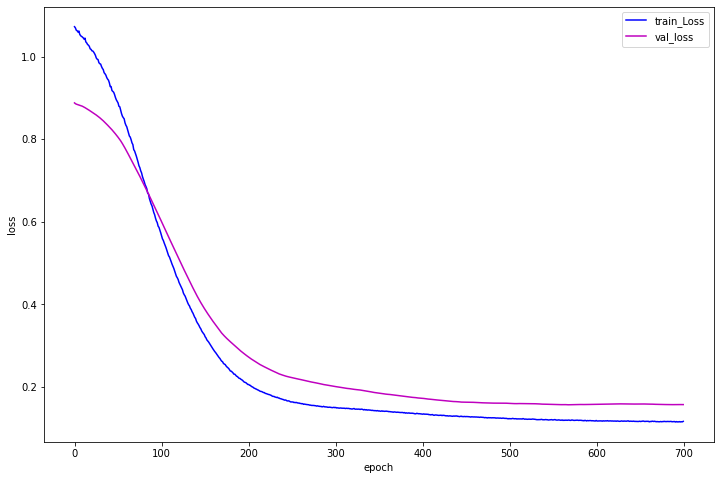

In [10]:
# 誤差関数の可視化
fig = plt.figure() # グラフの描画領域全体のオブジェクトを取得
fig.set_figheight(8) # 縦の幅を指定
fig.set_figwidth(12) # 横の幅を指定
plt.plot(train_loss_list, color='b', label='train_Loss')
plt.plot( val_loss_list, color='m', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
net.eval() # モデルを評価モードにする

# テストデータ用のデータローダを用意
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

y_pred = None
with torch.no_grad():
    # ミニバッチで取り出しながら、最初のバッチはy_predに設定し、
    # 2回目以降はそこへnumpy配列で接続していく
    for inputs, labels in test_dataloader:
        outputs = net(inputs)
        if y_pred is None:
            y_pred = outputs.data.numpy()
        else:
            y_pred = np.concatenate([y_pred, outputs.data.numpy()])

y_pred = y_pred.reshape(-1)

test_acc = r2_score(test_y_scaled, y_pred)
print('テストデータに対する予測精度：{:.6f}\n'.format(test_acc))

テストデータに対する予測精度：0.885136



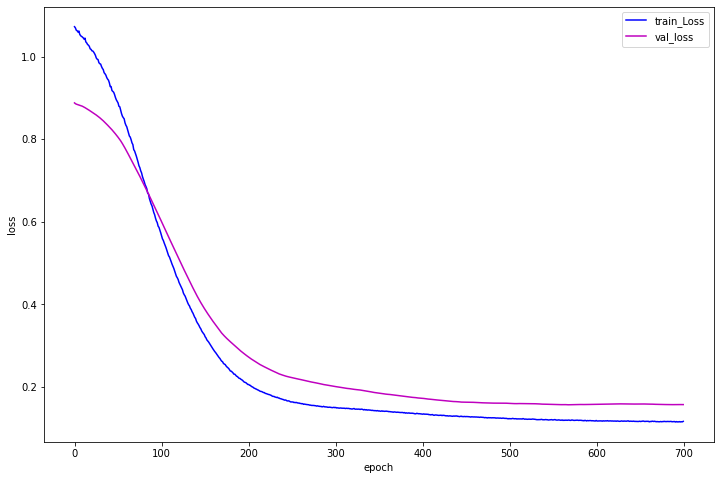

テストデータに対する予測精度：0.885136



In [12]:
# この後精度改善のために何度か確認するので、関数化しておきます
def myevaluete():

  # 誤差関数の可視化
  fig = plt.figure() # グラフの描画領域全体のオブジェクトを取得
  fig.set_figheight(8) # 縦の幅を指定
  fig.set_figwidth(12) # 横の幅を指定
  plt.plot(train_loss_list, color='b', label='train_Loss')
  plt.plot( val_loss_list, color='m', label='val_loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

  net.eval() # モデルを評価モードにする

  # テストデータ用のデータローダを用意
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

  y_pred = None
  with torch.no_grad():
      # ミニバッチで取り出しながら、最初のバッチはy_predに設定し、
      # 2回目以降はそこへnumpy配列で接続していく
      for inputs, labels in test_dataloader:
          outputs = net(inputs)
          if y_pred is None:
              y_pred = outputs.data.numpy()
          else:
              y_pred = np.concatenate([y_pred, outputs.data.numpy()])

  y_pred = y_pred.reshape(-1)

  test_acc = r2_score(test_y_scaled, y_pred)
  print('テストデータに対する予測精度：{:.6f}\n'.format(test_acc))

myevaluete()

## ニューラルネットワークモデルを改良する

In [13]:
# 乱数シードの固定
torch.manual_seed(0)

# ニューラルネットワークを定義
class Net(torch.nn.Module):

  # 必要な層や活性化関数を定義する
  def __init__(self):
    super(Net, self).__init__()
    self.l1 = torch.nn.Linear(train_x.shape[1], 128)     # 中間層1
    self.a1 = torch.nn.ReLU()  # 活性化関数1
    self.l2 = torch.nn.Linear(128, 128)   # 中間層2
    self.a2 = torch.nn.ReLU()  # 活性化関数2
    self.l3 = torch.nn.Linear(128, 1)     # 出力層

  # 順伝搬を定義。引数のxは、説明変数。
  # 順番に関数を実行し、その結果を次の関数に渡していく
  def forward(self, x):
    x = self.l1(x)
    x = self.a1(x)
    x = self.l2(x)
    x = self.a2(x)
    x = self.l3(x)
    return x

In [14]:
num_epochs = 700

# データローダーの用意
# PyTorchではデータローダーに格納されたデータセットをバッチサイズで区切って、学習のたびに取り出します。
# shuffleをTrueに設定することで、データをシャッフルして取り出します
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# モデルをインスタンス化
net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) # 最適化手法の用意
criterion = torch.nn.MSELoss() # 誤差関数の用意。回帰なので平均２乗誤差を使う

## 学習時に経過情報を保存する空リストを作成
train_loss_list = []      # 学習データの誤差関数用リスト
val_loss_list = []        # 検証データの誤差関数用リスト

# エポック分の繰り返し
for epoch in range(num_epochs):
    
    #学習の進行状況を表示
    print('--------')
    print("Epoch: {}/{}".format(epoch + 1, num_epochs))

    # 損失の初期化
    train_loss = 0        # 学習データの誤差関数
    val_loss = 0          # 検証データの誤差関数
    
    #=====学習パート=======
    # 学習モードに設定
    # PyTorchでは学習時と評価時でモードを切り替える
    net.train()

    #ミニバッチごとにデータをロードして学習
    for x, y in train_dataloader:
        preds = net(x)                            # 順伝搬で予測を実行
        loss = criterion(preds, y)                # 誤差関数を計算
        optimizer.zero_grad()                     # 勾配を初期化
        loss.backward()                           # 勾配を計算
        optimizer.step()                          # パラメータ更新
        train_loss += loss.data.numpy().tolist()  # ミニバッチごとの損失を格納   
    #ミニバッチの平均の損失を計算
    batch_train_loss = train_loss / len(train_dataloader)
    
    #=====評価パート(検証データ)=======
    # 評価モードに設定
    net.eval()
    # 評価時は勾配計算は不要なので、勾配計算を無効にして負荷を下げる
    with torch.no_grad():
        for x, y in val_dataloader:
            preds = net(x)                        # 順伝搬で予測を実行
            loss = criterion(preds, y)            # 誤差関数を計算
            val_loss += loss.item()               # ミニバッチごとの損失を備蓄    
    #ミニバッチの平均の損失を計算
    batch_val_loss = val_loss / len(val_dataloader)
    
    #エポックごとに損失を表示
    print("train_loss: {:.4f}".format(batch_train_loss))
    print("val_loss: {:.4f}".format(batch_val_loss))
    #損失をリスト化して保存
    train_loss_list.append(batch_train_loss)
    val_loss_list.append(batch_val_loss)

--------
Epoch: 1/700
train_loss: 0.9505
val_loss: 0.6808
--------
Epoch: 2/700
train_loss: 0.7109
val_loss: 0.4695
--------
Epoch: 3/700
train_loss: 0.5187
val_loss: 0.3216
--------
Epoch: 4/700
train_loss: 0.3801
val_loss: 0.2354
--------
Epoch: 5/700
train_loss: 0.2946
val_loss: 0.2087
--------
Epoch: 6/700
train_loss: 0.2597
val_loss: 0.2225
--------
Epoch: 7/700
train_loss: 0.2494
val_loss: 0.2389
--------
Epoch: 8/700
train_loss: 0.2434
val_loss: 0.2351
--------
Epoch: 9/700
train_loss: 0.2243
val_loss: 0.2092
--------
Epoch: 10/700
train_loss: 0.1968
val_loss: 0.1754
--------
Epoch: 11/700
train_loss: 0.1732
val_loss: 0.1490
--------
Epoch: 12/700
train_loss: 0.1582
val_loss: 0.1345
--------
Epoch: 13/700
train_loss: 0.1515
val_loss: 0.1294
--------
Epoch: 14/700
train_loss: 0.1478
val_loss: 0.1295
--------
Epoch: 15/700
train_loss: 0.1421
val_loss: 0.1324
--------
Epoch: 16/700
train_loss: 0.1365
val_loss: 0.1342
--------
Epoch: 17/700
train_loss: 0.1302
val_loss: 0.1344
------

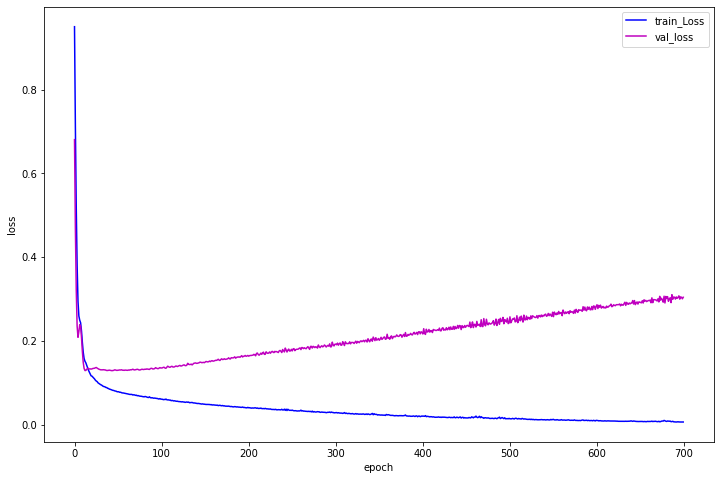

テストデータに対する予測精度：0.851107



In [15]:
myevaluete()

## 学習不足と過学習
ニューロンを増やした学習では、最初は順調に誤差が小さくなっていますが、検証データに対してはすぐに、改善するどころかどんどん誤差が大きくなっています。

しかし、この付近ではニューロンが少ないモデルよりも検証データへの誤差が小さくなっています。

最初のニューロンの少ないモデルは、まだデータに対して十分に適合できておらず、まだ改善の余地を残している適合不足の状態です。対して、ニューロンを増やしたモデルでは、訓練データに適合しすぎて過剰適合の状態です。

ニューラルネットワークの改良では、適合不足でもなく過剰適合でもない丁度よい状態を見つけることが必要になります。

また、ニューラルネットワークは他のモデルに比べて学習に非常に多くの時間がかかります。そこで、学習を効率的に進めることも合わせて考慮する必要があります。


## 早期終了とドロップアウト
以下の最適化を行い、学習の効率化とさらなる精度の向上を図ります。

- 早期終了
- ドロップアウト

いずれの手法もどんな場合でも効果的とは限らず精度が悪化する場合もあります。（早期終了は有用でなくてもデメリットは少ない）

PyTorchには標準で早期終了のための機能が用意されていないため、自作する必要があります。単純なパラメータのみで早期終了を行うためのプログラムを用意しましたので、今回はそれを使って早期終了機能を実装します。




In [16]:
# Early-Stopping機能を実装したクラス
class EarlyStopping:

  def __init__(self, patience=0):
    self._step = 0              # lossが改善しなかった連続回数をカウントする。先頭の_は内部的であることを表わしています
    self._loss = float('inf')   # そこまでで最も改善が見られたlossの値を格納する
    self.patience = patience    # 引数で指定する、何回改善されなかったら早期終了するかの回数

  def __call__(self, loss):
    if self._loss < loss:
      self._step += 1   # lossが改善しなければ_stepを1増やす
      if self._step >= self.patience:    # patienceの回数改善しなかったら早期終了する
        print('early stopping')
        return True
    else:               # lossが改善した場合は_stepを0にして_lossを更新する
      self._step = 0
      self._loss = loss
    return False

In [17]:
# 乱数シードの固定
torch.manual_seed(0)

# ニューラルネットワークを定義
class Net(torch.nn.Module):

  # 必要な層や活性化関数を定義する
  def __init__(self):
    super(Net, self).__init__()
    self.l1 = torch.nn.Linear(train_x.shape[1], 128)     # 中間層1
    self.a1 = torch.nn.ReLU()             # 活性化関数1
    self.d1 = torch.nn.Dropout(0.2)       # ★ドロップアウト層1★
    self.l2 = torch.nn.Linear(128, 128)   # 中間層2
    self.a2 = torch.nn.ReLU()             # 活性化関数2
    self.d2 = torch.nn.Dropout(0.2)       # ★ドロップアウト層2★
    self.l3 = torch.nn.Linear(128, 1)     # 出力層

  # 順伝搬を定義。引数のxは、説明変数。
  # 順番に関数を実行し、その結果を次の関数に渡していく
  def forward(self, x):
    x = self.l1(x)
    x = self.a1(x)
    x = self.d1(x) # ★ドロップアウト層1★
    x = self.l2(x)
    x = self.a2(x)
    x = self.d2(x) # ★ドロップアウト層2★
    x = self.l3(x)
    return x

In [18]:
num_epochs = 700

# データローダーの用意
# PyTorchではデータローダーに格納されたデータセットをバッチサイズで区切って、学習のたびに取り出します。
# shuffleをTrueに設定することで、データをシャッフルして取り出します
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ★早期終了のインスタンスを準備★
es = EarlyStopping(patience=10)

# モデルをインスタンス化
net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01) # 最適化手法の用意
criterion = torch.nn.MSELoss() # 誤差関数の用意。回帰なので平均２乗誤差を使う

## 学習時に経過情報を保存する空リストを作成
train_loss_list = []      # 学習データの誤差関数用リスト
val_loss_list = []        # 検証データの誤差関数用リスト

# エポック分の繰り返し
for epoch in range(num_epochs):
    
    #学習の進行状況を表示
    print('--------')
    print("Epoch: {}/{}".format(epoch + 1, num_epochs))

    # 損失の初期化
    train_loss = 0        # 学習データの誤差関数
    val_loss = 0          # 検証データの誤差関数
    
    #=====学習パート=======
    # 学習モードに設定
    # PyTorchでは学習時と評価時でモードを切り替える
    net.train()

    #ミニバッチごとにデータをロードして学習
    for x, y in train_dataloader:
        preds = net(x)                            # 順伝搬で予測を実行
        loss = criterion(preds, y)                # 誤差関数を計算
        optimizer.zero_grad()                     # 勾配を初期化
        loss.backward()                           # 勾配を計算
        optimizer.step()                          # パラメータ更新
        train_loss += loss.data.numpy().tolist()  # ミニバッチごとの損失を格納   
    #ミニバッチの平均の損失を計算
    batch_train_loss = train_loss / len(train_dataloader)
    
    #=====評価パート(検証データ)=======
    # 評価モードに設定
    net.eval()
    # 評価時は勾配計算は不要なので、勾配計算を無効にして負荷を下げる
    with torch.no_grad():
        for x, y in val_dataloader:
            preds = net(x)                        # 順伝搬で予測を実行
            loss = criterion(preds, y)            # 誤差関数を計算
            val_loss += loss.item()               # ミニバッチごとの損失を格納    
    #ミニバッチの平均の損失を計算
    batch_val_loss = val_loss / len(val_dataloader)
    
    #エポックごとに損失を表示
    print("Train_Loss: {:.4f}".format(batch_train_loss))
    print("val_loss: {:.4f}".format(batch_val_loss))
    #損失をリスト化して保存
    train_loss_list.append(batch_train_loss)
    val_loss_list.append(batch_val_loss)

    # ★早期終了判定★
    if es(batch_val_loss):
      break

--------
Epoch: 1/700
Train_Loss: 1.0001
val_loss: 0.8389
--------
Epoch: 2/700
Train_Loss: 0.8862
val_loss: 0.7468
--------
Epoch: 3/700
Train_Loss: 0.8257
val_loss: 0.6636
--------
Epoch: 4/700
Train_Loss: 0.7393
val_loss: 0.5893
--------
Epoch: 5/700
Train_Loss: 0.6923
val_loss: 0.5261
--------
Epoch: 6/700
Train_Loss: 0.6208
val_loss: 0.4692
--------
Epoch: 7/700
Train_Loss: 0.5629
val_loss: 0.4208
--------
Epoch: 8/700
Train_Loss: 0.5306
val_loss: 0.3773
--------
Epoch: 9/700
Train_Loss: 0.4720
val_loss: 0.3409
--------
Epoch: 10/700
Train_Loss: 0.4459
val_loss: 0.3088
--------
Epoch: 11/700
Train_Loss: 0.4285
val_loss: 0.2827
--------
Epoch: 12/700
Train_Loss: 0.3977
val_loss: 0.2628
--------
Epoch: 13/700
Train_Loss: 0.3654
val_loss: 0.2456
--------
Epoch: 14/700
Train_Loss: 0.3490
val_loss: 0.2321
--------
Epoch: 15/700
Train_Loss: 0.3515
val_loss: 0.2196
--------
Epoch: 16/700
Train_Loss: 0.3291
val_loss: 0.2120
--------
Epoch: 17/700
Train_Loss: 0.3370
val_loss: 0.2041
------

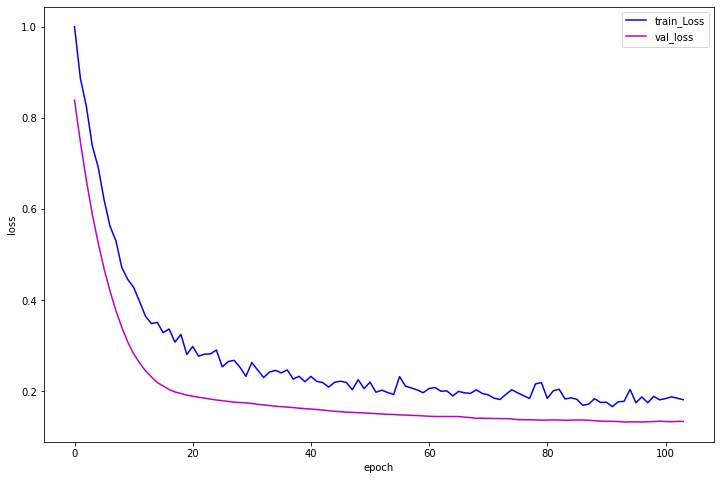

テストデータに対する予測精度：0.881052



In [19]:
myevaluete()